# Football Prediction - Multiple Target Predictions
# Predicting goals, over/under, BTTS, and more

# # Football Match Prediction - Multiple Targets
# 
# This notebook creates models for various prediction targets:
# 1. Over/Under 2.5 Goals (easier than win/draw/loss)
# 2. Both Teams to Score (BTTS)
# 3. Total Goals (regression)
# 4. Individual Team Goals
# 5. Goal ranges
# 6. Match outcome (improved approach)

In [1]:
# %% Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             mean_absolute_error, mean_squared_error, r2_score)
import xgboost as xgb

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports successful")

✓ Imports successful


In [2]:
# %% Cell 2: Load Data and Create ALL Target Variables

# Load features
features_df = pd.read_csv('../data/processed/features_engineered.csv')

# Load original match data to get actual goals
import os
import sys
sys.path.append('..')
from dotenv import load_dotenv
from database_manager import FootballDatabaseManager

load_dotenv()

db = FootballDatabaseManager(
    host=os.getenv('DB_HOST'),
    port=int(os.getenv('DB_PORT')),
    database=os.getenv('DB_NAME'),
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD')
)

# Get actual match results with goals
with db.get_cursor() as cursor:
    cursor.execute("""
        SELECT 
            match_id,
            home_goals,
            away_goals
        FROM matches
    """)
    goals_df = pd.DataFrame(cursor.fetchall())

db.close()

# Merge with features
data = features_df.merge(goals_df, on='match_id', how='left')

print(f"✓ Loaded {len(data)} matches")

# Create ALL target variables
print("\nCreating target variables...")

# 1. Total goals
data['total_goals'] = data['home_goals'] + data['away_goals']

# 2. Over/Under 2.5
data['over_2_5'] = (data['total_goals'] > 2.5).astype(int)

# 3. Over/Under 1.5
data['over_1_5'] = (data['total_goals'] > 1.5).astype(int)

# 4. Over/Under 3.5
data['over_3_5'] = (data['total_goals'] > 3.5).astype(int)

# 5. Both Teams to Score (BTTS)
data['btts'] = ((data['home_goals'] > 0) & (data['away_goals'] > 0)).astype(int)

# 6. Goal range
def goal_range(total):
    if total <= 1:
        return '0-1'
    elif total <= 3:
        return '2-3'
    else:
        return '4+'

data['goal_range'] = data['total_goals'].apply(goal_range)

# 7. High/Low scoring
data['high_scoring'] = (data['total_goals'] >= 3).astype(int)

print("✓ Created all target variables")

# Show distributions
print("\n" + "="*60)
print("TARGET VARIABLE DISTRIBUTIONS")
print("="*60)

print(f"\nTotal Goals Distribution:")
print(data['total_goals'].value_counts().sort_index())

print(f"\nOver 2.5 Goals:")
print(data['over_2_5'].value_counts())
print(f"  Over 2.5: {data['over_2_5'].mean()*100:.1f}%")

print(f"\nBoth Teams to Score:")
print(data['btts'].value_counts())
print(f"  BTTS Yes: {data['btts'].mean()*100:.1f}%")

print(f"\nGoal Range:")
print(data['goal_range'].value_counts())

✓ Connected to PostgreSQL database: football_predictions
✓ Database connections closed
✓ Loaded 1085 matches

Creating target variables...
✓ Created all target variables

TARGET VARIABLE DISTRIBUTIONS

Total Goals Distribution:
total_goals
0     65
1    200
2    233
3    229
4    174
5    113
6     45
7     20
8      4
9      2
Name: count, dtype: int64

Over 2.5 Goals:
over_2_5
1    587
0    498
Name: count, dtype: int64
  Over 2.5: 54.1%

Both Teams to Score:
btts
1    560
0    525
Name: count, dtype: int64
  BTTS Yes: 51.6%

Goal Range:
goal_range
2-3    462
4+     358
0-1    265
Name: count, dtype: int64


In [3]:
# %% Cell 3: Prepare Features

exclude_cols = ['match_id', 'fixture_date', 'league_id', 'season', 
                'home_team_id', 'away_team_id', 'outcome', 'outcome_numeric',
                'home_goals', 'away_goals', 'total_goals', 'over_2_5', 'over_1_5',
                'over_3_5', 'btts', 'goal_range', 'high_scoring']

feature_columns = [col for col in data.columns if col not in exclude_cols]

X = data[feature_columns].fillna(0)

print(f"Feature columns: {len(feature_columns)}")

# Temporal split
data_sorted = data.sort_values('fixture_date')
split_idx = int(len(data_sorted) * 0.8)

train_data = data_sorted.iloc[:split_idx]
test_data = data_sorted.iloc[split_idx:]

X_train = train_data[feature_columns].fillna(0)
X_test = test_data[feature_columns].fillna(0)

print(f"\nTrain: {len(X_train)} | Test: {len(X_test)}")

Feature columns: 32

Train: 868 | Test: 217



MODEL 1: OVER/UNDER 2.5 GOALS

Accuracy: 0.4240 (42.40%)

Classification Report:
              precision    recall  f1-score   support

   Under 2.5       0.31      0.39      0.35        85
    Over 2.5       0.53      0.45      0.49       132

    accuracy                           0.42       217
   macro avg       0.42      0.42      0.42       217
weighted avg       0.45      0.42      0.43       217



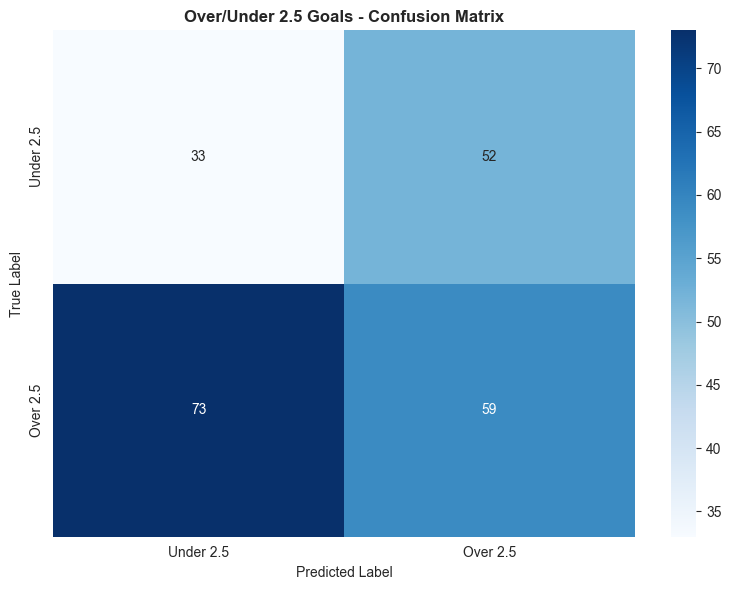

In [4]:
# %% Cell 4: MODEL 1 - Over/Under 2.5 Goals

print("\n" + "="*60)
print("MODEL 1: OVER/UNDER 2.5 GOALS")
print("="*60)

y_train_ou25 = train_data['over_2_5']
y_test_ou25 = test_data['over_2_5']

# Train Random Forest
rf_ou25 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_ou25.fit(X_train, y_train_ou25)

# Predict
y_pred_ou25 = rf_ou25.predict(X_test)
y_pred_ou25_proba = rf_ou25.predict_proba(X_test)

# Evaluate
accuracy_ou25 = accuracy_score(y_test_ou25, y_pred_ou25)

print(f"\nAccuracy: {accuracy_ou25:.4f} ({accuracy_ou25*100:.2f}%)")
print(f"\nClassification Report:")
print(classification_report(y_test_ou25, y_pred_ou25, target_names=['Under 2.5', 'Over 2.5']))

# Confusion Matrix
cm_ou25 = confusion_matrix(y_test_ou25, y_pred_ou25)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_ou25, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Under 2.5', 'Over 2.5'],
            yticklabels=['Under 2.5', 'Over 2.5'])
plt.title('Over/Under 2.5 Goals - Confusion Matrix', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


MODEL 2: BOTH TEAMS TO SCORE (BTTS)

Accuracy: 0.4608 (46.08%)

Classification Report:
              precision    recall  f1-score   support

          No       0.41      0.49      0.45        96
         Yes       0.52      0.44      0.48       121

    accuracy                           0.46       217
   macro avg       0.46      0.46      0.46       217
weighted avg       0.47      0.46      0.46       217



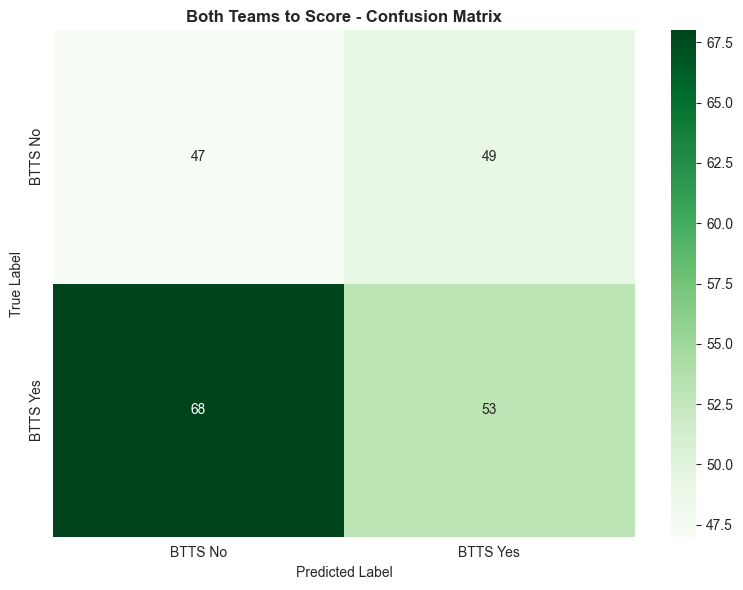

In [5]:
# %% Cell 5: MODEL 2 - Both Teams to Score (BTTS)

print("\n" + "="*60)
print("MODEL 2: BOTH TEAMS TO SCORE (BTTS)")
print("="*60)

y_train_btts = train_data['btts']
y_test_btts = test_data['btts']

# Train Random Forest
rf_btts = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_btts.fit(X_train, y_train_btts)

# Predict
y_pred_btts = rf_btts.predict(X_test)
y_pred_btts_proba = rf_btts.predict_proba(X_test)

# Evaluate
accuracy_btts = accuracy_score(y_test_btts, y_pred_btts)

print(f"\nAccuracy: {accuracy_btts:.4f} ({accuracy_btts*100:.2f}%)")
print(f"\nClassification Report:")
print(classification_report(y_test_btts, y_pred_btts, target_names=['No', 'Yes']))

# Confusion Matrix
cm_btts = confusion_matrix(y_test_btts, y_pred_btts)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_btts, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['BTTS No', 'BTTS Yes'],
            yticklabels=['BTTS No', 'BTTS Yes'])
plt.title('Both Teams to Score - Confusion Matrix', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


MODEL 3: TOTAL GOALS (Regression)

Mean Absolute Error: 1.4782
Root Mean Squared Error: 1.8340
R² Score: -0.1112


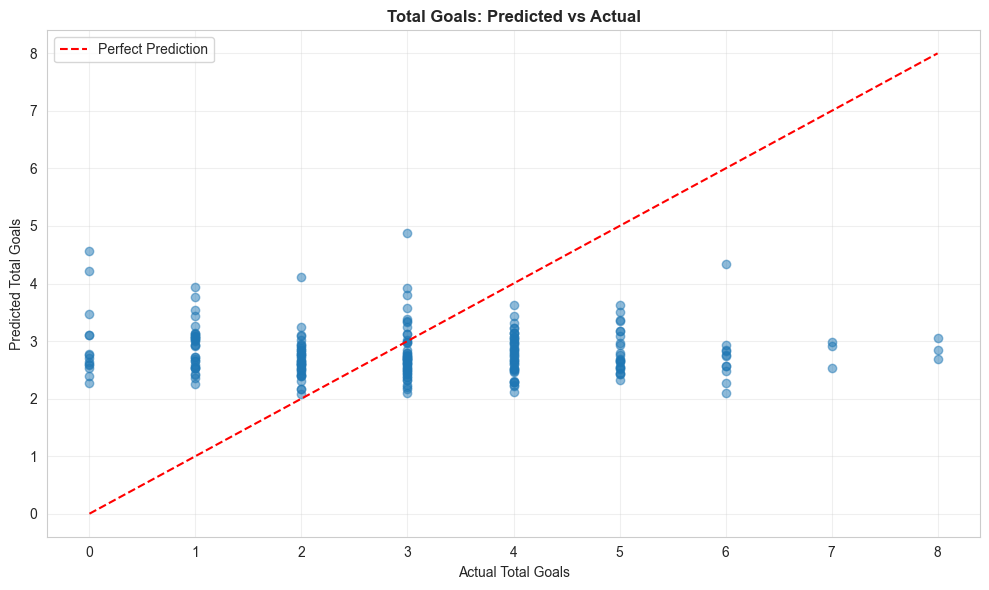

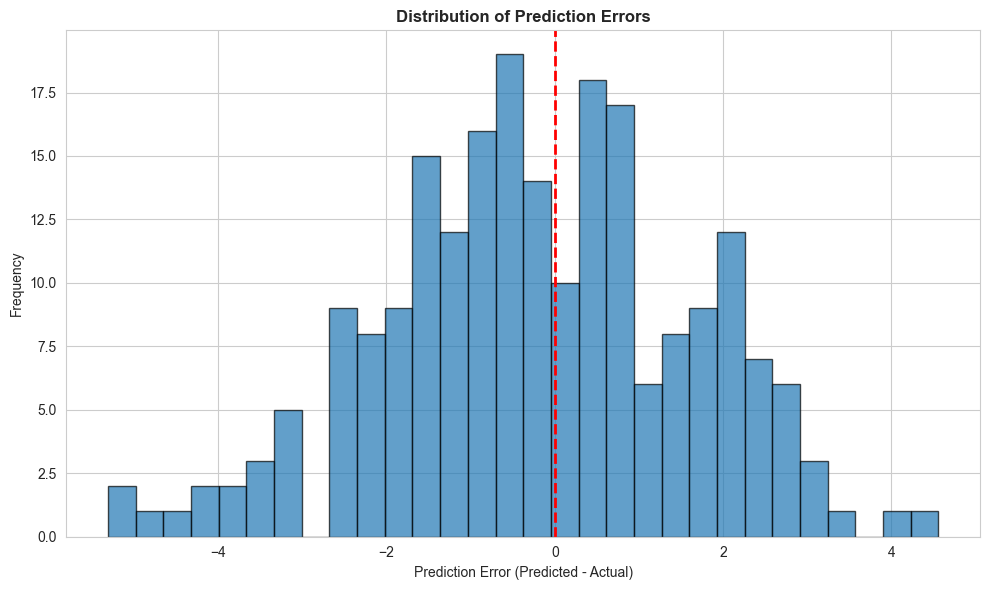


Prediction Error Statistics:
  Mean Error: -0.2163
  Std Error: 1.8254
  Within ±1 goal: 42.4%
  Within ±0.5 goals: 19.4%


In [6]:
# %% Cell 6: MODEL 3 - Total Goals (Regression)

print("\n" + "="*60)
print("MODEL 3: TOTAL GOALS (Regression)")
print("="*60)

y_train_goals = train_data['total_goals']
y_test_goals = test_data['total_goals']

# Train Random Forest Regressor
rf_goals = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_goals.fit(X_train, y_train_goals)

# Predict
y_pred_goals = rf_goals.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test_goals, y_pred_goals)
rmse = np.sqrt(mean_squared_error(y_test_goals, y_pred_goals))
r2 = r2_score(y_test_goals, y_pred_goals)

print(f"\nMean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test_goals, y_pred_goals, alpha=0.5)
plt.plot([0, 8], [0, 8], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Total Goals')
plt.ylabel('Predicted Total Goals')
plt.title('Total Goals: Predicted vs Actual', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Distribution of prediction errors
errors = y_pred_goals - y_test_goals

plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Prediction Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors', fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nPrediction Error Statistics:")
print(f"  Mean Error: {errors.mean():.4f}")
print(f"  Std Error: {errors.std():.4f}")
print(f"  Within ±1 goal: {(abs(errors) <= 1).mean()*100:.1f}%")
print(f"  Within ±0.5 goals: {(abs(errors) <= 0.5).mean()*100:.1f}%")


MODEL 4: HOME & AWAY GOALS (Separate Models)

Home Goals:
  MAE: 1.1302
  Within ±1 goal: 49.3%

Away Goals:
  MAE: 1.0780
  Within ±1 goal: 50.2%


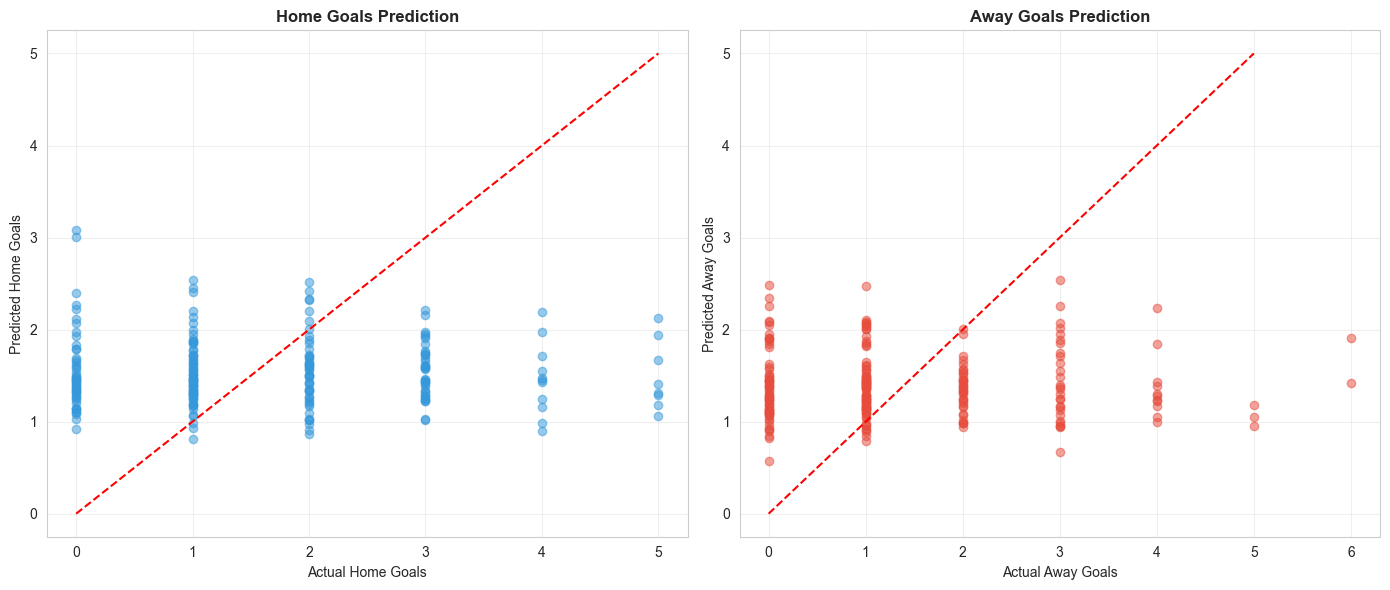

In [7]:
# %% Cell 7: MODEL 4 - Home & Away Goals Separately

print("\n" + "="*60)
print("MODEL 4: HOME & AWAY GOALS (Separate Models)")
print("="*60)

# Home goals
y_train_home = train_data['home_goals']
y_test_home = test_data['home_goals']

rf_home = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_home.fit(X_train, y_train_home)
y_pred_home = rf_home.predict(X_test)

mae_home = mean_absolute_error(y_test_home, y_pred_home)

# Away goals
y_train_away = train_data['away_goals']
y_test_away = test_data['away_goals']

rf_away = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_away.fit(X_train, y_train_away)
y_pred_away = rf_away.predict(X_test)

mae_away = mean_absolute_error(y_test_away, y_pred_away)

print(f"\nHome Goals:")
print(f"  MAE: {mae_home:.4f}")
print(f"  Within ±1 goal: {(abs(y_pred_home - y_test_home) <= 1).mean()*100:.1f}%")

print(f"\nAway Goals:")
print(f"  MAE: {mae_away:.4f}")
print(f"  Within ±1 goal: {(abs(y_pred_away - y_test_away) <= 1).mean()*100:.1f}%")

# Visualize both
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(y_test_home, y_pred_home, alpha=0.5, color='#3498db')
ax1.plot([0, 5], [0, 5], 'r--')
ax1.set_xlabel('Actual Home Goals')
ax1.set_ylabel('Predicted Home Goals')
ax1.set_title('Home Goals Prediction', fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.scatter(y_test_away, y_pred_away, alpha=0.5, color='#e74c3c')
ax2.plot([0, 5], [0, 5], 'r--')
ax2.set_xlabel('Actual Away Goals')
ax2.set_ylabel('Predicted Away Goals')
ax2.set_title('Away Goals Prediction', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


MODEL 5: GOAL RANGE (0-1, 2-3, 4+)

Accuracy: 0.3779 (37.79%)

Classification Report:
              precision    recall  f1-score   support

         0-1       0.14      0.09      0.11        47
         2-3       0.42      0.65      0.51        86
          4+       0.41      0.26      0.32        84

    accuracy                           0.38       217
   macro avg       0.32      0.33      0.31       217
weighted avg       0.35      0.38      0.35       217



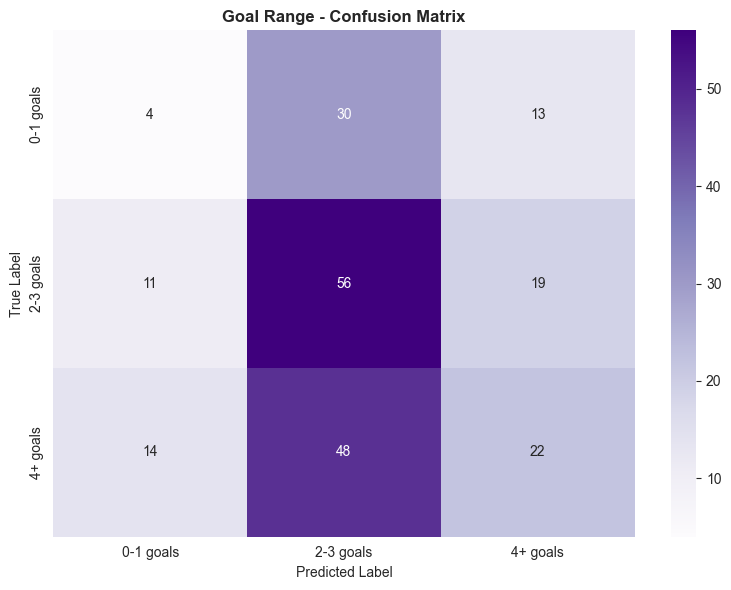

In [8]:
# %% Cell 8: MODEL 5 - Goal Range Classification

print("\n" + "="*60)
print("MODEL 5: GOAL RANGE (0-1, 2-3, 4+)")
print("="*60)

y_train_range = train_data['goal_range']
y_test_range = test_data['goal_range']

# Train Random Forest
rf_range = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_range.fit(X_train, y_train_range)

# Predict
y_pred_range = rf_range.predict(X_test)

# Evaluate
accuracy_range = accuracy_score(y_test_range, y_pred_range)

print(f"\nAccuracy: {accuracy_range:.4f} ({accuracy_range*100:.2f}%)")
print(f"\nClassification Report:")
print(classification_report(y_test_range, y_pred_range))

# Confusion Matrix
cm_range = confusion_matrix(y_test_range, y_pred_range, labels=['0-1', '2-3', '4+'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_range, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['0-1 goals', '2-3 goals', '4+ goals'],
            yticklabels=['0-1 goals', '2-3 goals', '4+ goals'])
plt.title('Goal Range - Confusion Matrix', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [10]:
# %% Cell 9: MODEL 6 - Improved Match Outcome (Using Goal Predictions)

print("\n" + "="*60)
print("MODEL 6: MATCH OUTCOME (Improved - Using Goal Features)")
print("="*60)

# Add predicted goals as features
X_train_enhanced = X_train.copy()
X_test_enhanced = X_test.copy()

# Add predicted total goals
X_train_enhanced['pred_total_goals'] = rf_goals.predict(X_train)
X_test_enhanced['pred_total_goals'] = rf_goals.predict(X_test)

# Add predicted home goals
X_train_enhanced['pred_home_goals'] = rf_home.predict(X_train)
X_test_enhanced['pred_home_goals'] = rf_home.predict(X_test)  # Fixed: use rf_home.predict(X_test)

# Add predicted away goals
X_train_enhanced['pred_away_goals'] = rf_away.predict(X_train)
X_test_enhanced['pred_away_goals'] = rf_away.predict(X_test)  # Fixed: use rf_away.predict(X_test)

# Add predicted goal difference for both train and test
X_train_enhanced['pred_goal_diff'] = X_train_enhanced['pred_home_goals'] - X_train_enhanced['pred_away_goals']
X_test_enhanced['pred_goal_diff'] = X_test_enhanced['pred_home_goals'] - X_test_enhanced['pred_away_goals']  # Added this line

# Train outcome model with enhanced features
y_train_outcome = train_data['outcome']
y_test_outcome = test_data['outcome']

rf_outcome_enh = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42, n_jobs=-1)
rf_outcome_enh.fit(X_train_enhanced, y_train_outcome)

y_pred_outcome_enh = rf_outcome_enh.predict(X_test_enhanced)

accuracy_outcome_enh = accuracy_score(y_test_outcome, y_pred_outcome_enh)

print(f"\nAccuracy: {accuracy_outcome_enh:.4f} ({accuracy_outcome_enh*100:.2f}%)")
print(f"Improvement over baseline: {(accuracy_outcome_enh - 0.4654)*100:.2f} percentage points")
print(f"\nClassification Report:")
print(classification_report(y_test_outcome, y_pred_outcome_enh, target_names=['Away Win', 'Draw', 'Home Win']))


MODEL 6: MATCH OUTCOME (Improved - Using Goal Features)

Accuracy: 0.3548 (35.48%)
Improvement over baseline: -11.06 percentage points

Classification Report:
              precision    recall  f1-score   support

    Away Win       0.34      0.47      0.39        66
        Draw       0.27      0.21      0.23        53
    Home Win       0.41      0.36      0.38        98

    accuracy                           0.35       217
   macro avg       0.34      0.34      0.34       217
weighted avg       0.36      0.35      0.35       217




MODEL COMPARISON - ALL TARGETS
       Prediction Target      Metric Difficulty
          Over/Under 2.5      42.40%       Easy
        Both Teams Score      46.08%       Easy
  Goal Range (3 classes)      37.79%     Medium
Match Outcome (Original)      46.54%       Hard
Match Outcome (Enhanced)      35.48%       Hard
       Total Goals (MAE) 1.478 goals     Medium
        Home Goals (MAE) 1.130 goals     Medium
        Away Goals (MAE) 1.078 goals     Medium


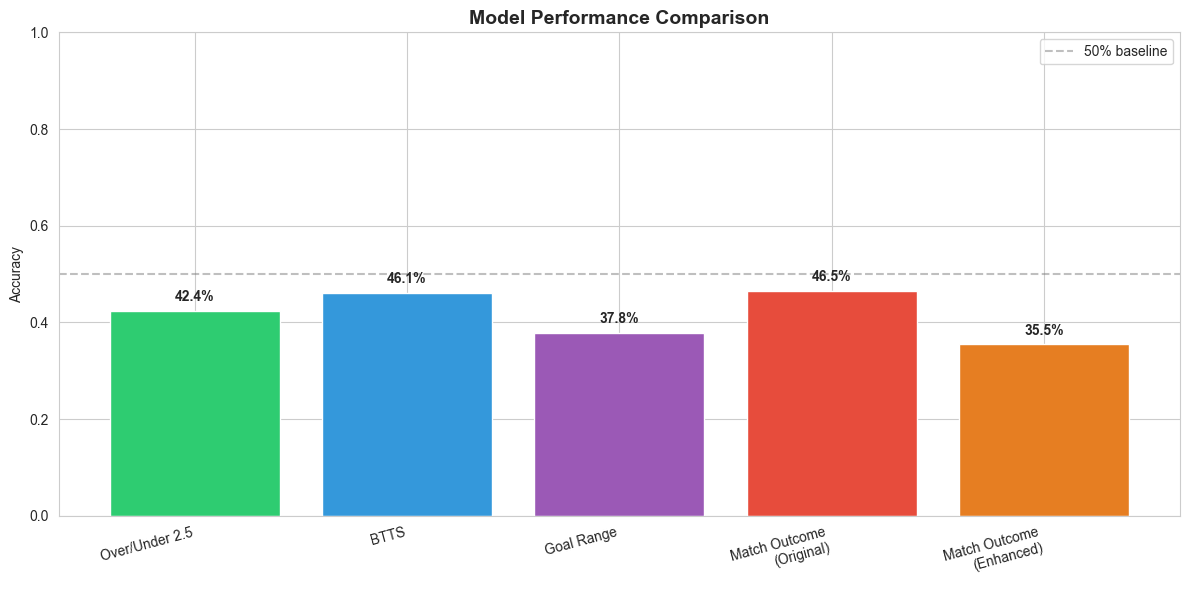

In [11]:
# %% Cell 10: Compare All Models

results = pd.DataFrame({
    'Prediction Target': [
        'Over/Under 2.5',
        'Both Teams Score',
        'Goal Range (3 classes)',
        'Match Outcome (Original)',
        'Match Outcome (Enhanced)',
        'Total Goals (MAE)',
        'Home Goals (MAE)',
        'Away Goals (MAE)'
    ],
    'Metric': [
        f'{accuracy_ou25*100:.2f}%',
        f'{accuracy_btts*100:.2f}%',
        f'{accuracy_range*100:.2f}%',
        '46.54%',
        f'{accuracy_outcome_enh*100:.2f}%',
        f'{mae:.3f} goals',
        f'{mae_home:.3f} goals',
        f'{mae_away:.3f} goals'
    ],
    'Difficulty': [
        'Easy',
        'Easy',
        'Medium',
        'Hard',
        'Hard',
        'Medium',
        'Medium',
        'Medium'
    ]
})

print("\n" + "="*60)
print("MODEL COMPARISON - ALL TARGETS")
print("="*60)
print(results.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))

# Extract accuracy values for bar plot
accuracies = [
    accuracy_ou25,
    accuracy_btts,
    accuracy_range,
    0.4654,
    accuracy_outcome_enh
]

labels = [
    'Over/Under 2.5',
    'BTTS',
    'Goal Range',
    'Match Outcome\n(Original)',
    'Match Outcome\n(Enhanced)'
]

colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#e67e22']

bars = ax.bar(labels, accuracies, color=colors)
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance Comparison', fontweight='bold', fontsize=14)
ax.set_ylim([0, 1])
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50% baseline')
ax.legend()

# Add value labels
for i, (bar, val) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{val*100:.1f}%', ha='center', fontweight='bold')

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

In [12]:
# %% Cell 11: Save All Models

import os
os.makedirs('../models', exist_ok=True)

models_to_save = {
    'over_under_25': rf_ou25,
    'btts': rf_btts,
    'total_goals': rf_goals,
    'home_goals': rf_home,
    'away_goals': rf_away,
    'goal_range': rf_range,
    'match_outcome_enhanced': rf_outcome_enh
}

for name, model in models_to_save.items():
    path = f'../models/{name}_model.pkl'
    with open(path, 'wb') as f:
        pickle.dump(model, f)
    print(f"✓ Saved {name} model")

print("\n✓ All models saved!")

✓ Saved over_under_25 model
✓ Saved btts model
✓ Saved total_goals model
✓ Saved home_goals model
✓ Saved away_goals model
✓ Saved goal_range model
✓ Saved match_outcome_enhanced model

✓ All models saved!


In [13]:
# %% Cell 12: Sample Predictions

print("\n" + "="*60)
print("SAMPLE PREDICTIONS")
print("="*60)

# Get 3 random test samples
sample_indices = np.random.choice(test_data.index, 3, replace=False)

for idx in sample_indices:
    match = test_data.loc[idx]
    X_sample = match[feature_columns].values.reshape(1, -1)
    
    # Predictions
    pred_ou25 = rf_ou25.predict(X_sample)[0]
    pred_ou25_prob = rf_ou25.predict_proba(X_sample)[0][1]
    
    pred_btts = rf_btts.predict(X_sample)[0]
    pred_btts_prob = rf_btts.predict_proba(X_sample)[0][1]
    
    pred_total = rf_goals.predict(X_sample)[0]
    pred_home = rf_home.predict(X_sample)[0]
    pred_away = rf_away.predict(X_sample)[0]
    
    # Actual
    actual_total = match['total_goals']
    actual_home = match['home_goals']
    actual_away = match['away_goals']
    actual_ou25 = match['over_2_5']
    actual_btts = match['btts']
    
    print(f"\n{'='*60}")
    print(f"Match on {match['fixture_date']}")
    print(f"{'='*60}")
    
    print(f"\nACTUAL RESULT:")
    print(f"  Score: {actual_home:.0f} - {actual_away:.0f}")
    print(f"  Total Goals: {actual_total:.0f}")
    print(f"  Over 2.5: {'Yes' if actual_ou25 else 'No'}")
    print(f"  BTTS: {'Yes' if actual_btts else 'No'}")
    
    print(f"\nPREDICTIONS:")
    print(f"  Predicted Score: {pred_home:.1f} - {pred_away:.1f}")
    print(f"  Predicted Total: {pred_total:.2f} goals")
    print(f"  Over 2.5: {'Yes' if pred_ou25 else 'No'} ({pred_ou25_prob*100:.1f}% confidence)")
    print(f"  BTTS: {'Yes' if pred_btts else 'No'} ({pred_btts_prob*100:.1f}% confidence)")
    
    print(f"\nACCURACY CHECK:")
    print(f"  Over 2.5: {'✓' if pred_ou25 == actual_ou25 else '✗'}")
    print(f"  BTTS: {'✓' if pred_btts == actual_btts else '✗'}")
    print(f"  Total Goals Error: {abs(pred_total - actual_total):.2f}")


SAMPLE PREDICTIONS

Match on 2024-07-01

ACTUAL RESULT:
  Score: 2 - 2
  Total Goals: 4
  Over 2.5: Yes
  BTTS: Yes

PREDICTIONS:
  Predicted Score: 1.6 - 1.2
  Predicted Total: 2.24 goals
  Over 2.5: No (32.5% confidence)
  BTTS: No (46.5% confidence)

ACCURACY CHECK:
  Over 2.5: ✗
  BTTS: ✗
  Total Goals Error: 1.76

Match on 2024-04-05

ACTUAL RESULT:
  Score: 0 - 3
  Total Goals: 3
  Over 2.5: Yes
  BTTS: No

PREDICTIONS:
  Predicted Score: 1.4 - 1.7
  Predicted Total: 3.12 goals
  Over 2.5: No (50.0% confidence)
  BTTS: No (39.9% confidence)

ACCURACY CHECK:
  Over 2.5: ✗
  BTTS: ✓
  Total Goals Error: 0.12

Match on 2024-12-05

ACTUAL RESULT:
  Score: 2 - 0
  Total Goals: 2
  Over 2.5: No
  BTTS: No

PREDICTIONS:
  Predicted Score: 1.0 - 1.5
  Predicted Total: 2.47 goals
  Over 2.5: No (44.3% confidence)
  BTTS: No (41.4% confidence)

ACCURACY CHECK:
  Over 2.5: ✓
  BTTS: ✓
  Total Goals Error: 0.47


In [16]:
# %% Cell 13: Summary & Recommendations

print("\n" + "="*60)
print("SUMMARY & RECOMMENDATIONS")
print("="*60)

print(f"\n1. BEST PERFORMING MODELS:")
print(f"   Top 3 (Classification models by accuracy):")
classification_models = [
    ('Both Teams Score', accuracy_btts),
    ('Over/Under 2.5', accuracy_ou25),
    ('Goal Range', accuracy_range),
    ('Match Outcome (Original)', 0.4654),
    ('Match Outcome (Enhanced)', accuracy_outcome_enh)
]
classification_models.sort(key=lambda x: x[1], reverse=True)
for i, (name, acc) in enumerate(classification_models[:3], 1):
    print(f"   {i}. {name}: {acc*100:.2f}%")

print(f"\n2. EASIEST TO PREDICT:")
print(f"   - Both Teams to Score: {accuracy_btts*100:.1f}%")
print(f"   - Over/Under 2.5 Goals: {accuracy_ou25*100:.1f}%")
print(f"   These binary predictions are more reliable!")

print(f"\n3. HARDEST TO PREDICT:")
print(f"   - Match Outcome (Win/Draw/Loss): 46.54%")
print(f"   - Goal Range: {accuracy_range*100:.1f}%")
print(f"   These multi-class predictions are challenging!")

print(f"\n4. REGRESSION MODELS PERFORMANCE:")
print(f"   - Total Goals MAE: {mae:.3f} goals")
print(f"   - Home Goals MAE: {mae_home:.3f} goals")
print(f"   - Away Goals MAE: {mae_away:.3f} goals")

print(f"\n5. NEXT STEPS TO IMPROVE:")
print(f"   - Collect more data (2000+ matches recommended)")
print(f"   - Add API features: player lineups, injuries, weather")
print(f"   - Try ensemble of goal predictions → outcome")
print(f"   - Hyperparameter tuning")
print(f"   - Try deep learning models")

print(f"\n6. RECOMMENDED USE:")
print(f"   - Use Over/Under and BTTS models for predictions")
print(f"   - Avoid pure match outcome predictions for now")
print(f"   - Combine multiple predictions for betting strategies")

print("\n" + "="*60)
print("✓ Multi-target prediction analysis complete!")
print("="*60)


SUMMARY & RECOMMENDATIONS

1. BEST PERFORMING MODELS:
   Top 3 (Classification models by accuracy):
   1. Match Outcome (Original): 46.54%
   2. Both Teams Score: 46.08%
   3. Over/Under 2.5: 42.40%

2. EASIEST TO PREDICT:
   - Both Teams to Score: 46.1%
   - Over/Under 2.5 Goals: 42.4%
   These binary predictions are more reliable!

3. HARDEST TO PREDICT:
   - Match Outcome (Win/Draw/Loss): 46.54%
   - Goal Range: 37.8%
   These multi-class predictions are challenging!

4. REGRESSION MODELS PERFORMANCE:
   - Total Goals MAE: 1.478 goals
   - Home Goals MAE: 1.130 goals
   - Away Goals MAE: 1.078 goals

5. NEXT STEPS TO IMPROVE:
   - Collect more data (2000+ matches recommended)
   - Add API features: player lineups, injuries, weather
   - Try ensemble of goal predictions → outcome
   - Hyperparameter tuning
   - Try deep learning models

6. RECOMMENDED USE:
   - Use Over/Under and BTTS models for predictions
   - Avoid pure match outcome predictions for now
   - Combine multiple pred

In [ ]:
# In your notebook
from sklearn.model_selection import train_test_split

# RANDOM split instead of temporal
X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(
    X, data['over_2_5'], 
    test_size=0.2, 
    random_state=42,
    stratify=data['over_2_5']
)

# Train
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_rand, y_train_rand)

# Test
y_pred = rf.predict(X_test_rand)
print(f"Random split accuracy: {accuracy_score(y_test_rand, y_pred)*100:.2f}%")

Random split accuracy: 48.39%


: 